# ISYE 6740 - ISOMAP


### Section 1. Order of faces using ISOMAP

This question aims to reproduce the ISOMAP algorithm results in the original paper for
ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323.


#### import all packages:

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib.pyplot import imshow, subplots
from Matrix_D import *

#### preparation for the data:

In [2]:
images = loadmat('data/isomap.mat')['images']

In [3]:
img = pd.DataFrame(images.T)
img


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.016176,0.016176,0.016176,0.016176,0.016988,0.028140,0.047518,0.050950,0.080469,0.116146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.016176,0.016176,0.016176,0.024188,0.039859,0.040671,0.038710,0.035983,0.034559,0.033517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
694,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
696,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.016176,0.031388,0.130867,0.274341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
img.shape

(698, 4096)

In [5]:
#there are m data points, n features for each data point
m = img.shape[0]
n = img.shape[1]

#### Question (a) Build a weighted nearest neighbor graph (an Adjacency Matrix)
Choose the Euclidean distance or Manhattan distance to construct the
nearest neighbor graph|vertices corresponding to the images. Construct a similarity graph
with vertices corresponding to the images, and tune the threshold e so that each node has
at least K = 50 neighbors (this approach corresponds to the so-called e-Isomap).

In [6]:
#Utility functions are created here:

#step1(a): Calculate Euclidean distance for the weighted nearest neighbor graph
def euclidean_distance(x,y):
    '''
    x -> int
    y -> int
    rtype -> numpy.array
    '''
    return np.linalg.norm((x-y), ord = 2)


#step1(b): Calculate Manhattan distance for the weighted nearest neighbor graph
def manhattan_distance(x,y):
    '''
    x -> int
    y -> int
    rtype -> numpy.array
    '''
    return np.linalg.norm((x-y),ord = 1)

#step 2: create an adjacency matrix to store all the distances among each datapoint. 
#Use either Euclidean distance or Manhattan distance

def build_similarity_graph(data,distance=2):
    m = data.shape[0]
    A = np.empty(shape= (m,m))
    
    if distance ==1: #if select Manhatan distance
        for i in range(m):
            for j in range(m):
                ma_distance = manhattan_distance(img[i],img[j])
                A[i,j] = A[j,i] = ma_distance #due to it is an adjacency matrix, A[i,j] == A[j,i]
    else: #by default use Eucliean distance
        for i in range(m):
            for j in range(m):
                eu_distance = euclidean_distance(img[i],img[j])
                A[i,j] = A[j,i] = eu_distance
        
    return A



#step 3: Calculate a thehold to ensure each node will have at least 50 neighbors.
def find_threhold(A,num=50):
    '''
    A -> a np.array
    num -> int , it is the least number of neighbors each node should have
    return -> float64
    '''
    A_sort = np.sort(A)
    return max(A_sort[:,num])

#step 4: update the similarity graph
#if the eu_distance between the nodes is greater than threshold, the the node-node pair will be opt out (set as inf)
def update_similarity_graph(A,threshold):
    '''
    A -> np.array
    threshold -> float64
    return -> np.array
    '''
    m = A.shape[0]
    for i in range(m):
        for j in range(m):
            if A[i,j] > threshold:
                A[i,j] = A[j,i] = np.inf
                
    return A

#step 5: create a quick function to assert each node is at least connected to 50 other nodes
def check_matrix(matrix,num):
    '''
    matrix -> np.array
    num -> int
    rtype -> None
    '''
    min_neighbor = min(np.count_nonzero(~np.isinf(matrix), axis=1))
    if (min_neighbor) - num > 0:
        print('Great! There are at least {} neighors for each node in the matrix!'.format(min_neighbor))
    else:
        print('Something is off. There are at least {} neighors for each node in the matrix.'.format(min_neighbor))

# def check_updated_matrix(matrix,num=50):
#     return np.count_nonzero(matrix >= 0, axis=0).all()

In [7]:
A = build_similarity_graph(img,distance=2)

In [8]:
pd.DataFrame(A[:5])

,0,1,2,3,4,5,6,7,8,9,...,688,689,690,691,692,693,694,695,696,697
0,0.000000,0.431772,0.897439,0.984075,1.243680,1.779560,1.952054,2.228383,2.723717,2.916137,...,4.918928,4.807694,4.821495,4.948007,5.146610,5.398434,5.635480,5.844189,5.948118,5.914588
1,0.431772,0.000000,0.529317,0.746013,1.072266,1.604557,1.764437,2.052541,2.595581,2.821909,...,4.900073,4.785308,4.794254,4.916260,5.112074,5.361108,5.596367,5.803848,5.907082,5.873218
2,0.897439,0.529317,0.000000,0.512629,0.932251,1.424737,1.607448,1.868762,2.468290,2.775933,...,4.890686,4.774385,4.778715,4.894498,5.084651,5.327266,5.556394,5.759240,5.858941,5.823213
3,0.984075,0.746013,0.512629,0.000000,0.622310,1.238648,1.458672,1.770693,2.365475,2.654667,...,4.830712,4.708335,4.707602,4.819118,5.007688,5.249822,5.477544,5.679661,5.778264,5.740848
4,1.243680,1.072266,0.932251,0.622310,0.000000,0.827304,1.192400,1.584743,2.234648,2.506292,...,4.789009,4.663322,4.649233,4.744647,4.919528,5.153840,5.379786,5.585152,5.689616,5.656070


In [9]:
#Calculate a thehold to ensure each node will have at least 50 neighbors.

threshold = find_threhold(A,num=50)
threshold

10.422873911135428

In [10]:
#pdate the similarity graph
#if the eu_distance between the nodes is greater than threshold, the the node-node pair will be opt out (set as inf)
A_update = update_similarity_graph(A,threshold)

In [11]:
pd.DataFrame(A_update[:5])

,0,1,2,3,4,5,6,7,8,9,...,688,689,690,691,692,693,694,695,696,697
0,0.000000,0.431772,0.897439,0.984075,1.243680,1.779560,1.952054,2.228383,2.723717,2.916137,...,4.918928,4.807694,4.821495,4.948007,5.146610,5.398434,5.635480,5.844189,5.948118,5.914588
1,0.431772,0.000000,0.529317,0.746013,1.072266,1.604557,1.764437,2.052541,2.595581,2.821909,...,4.900073,4.785308,4.794254,4.916260,5.112074,5.361108,5.596367,5.803848,5.907082,5.873218
2,0.897439,0.529317,0.000000,0.512629,0.932251,1.424737,1.607448,1.868762,2.468290,2.775933,...,4.890686,4.774385,4.778715,4.894498,5.084651,5.327266,5.556394,5.759240,5.858941,5.823213
3,0.984075,0.746013,0.512629,0.000000,0.622310,1.238648,1.458672,1.770693,2.365475,2.654667,...,4.830712,4.708335,4.707602,4.819118,5.007688,5.249822,5.477544,5.679661,5.778264,5.740848
4,1.243680,1.072266,0.932251,0.622310,0.000000,0.827304,1.192400,1.584743,2.234648,2.506292,...,4.789009,4.663322,4.649233,4.744647,4.919528,5.153840,5.379786,5.585152,5.689616,5.656070


In [12]:
#assert each node is at least connected to 50 other nodes
check_matrix(A_update,50)

Great! There are at least 51 neighors for each node in the matrix!


#### Visualize the similarity graph:

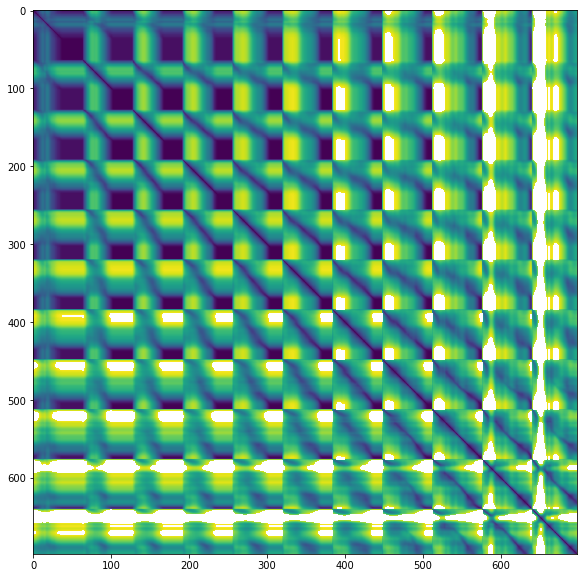

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(A_update)

In [14]:
A_update.shape

(698, 698)

Text(0.5, 1.0, 'embedding_image_3')

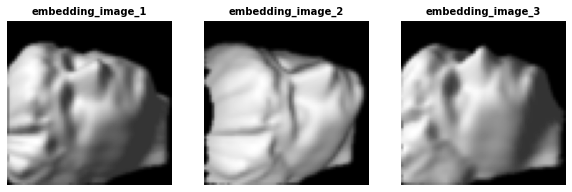

In [15]:
intro_fig, ax = subplots(1,3, figsize=(10,10))

idx = np.argsort(A_update[:,0])
img_1 = np.reshape(images.T[idx[0]], [64, -1])
img_2 = np.reshape(images.T[idx[300]], [64, -1])
img_3 = np.reshape(images.T[idx[650]], [64, -1])


ax[0].axis('off')
ax[0].imshow(img_1,cmap = 'gray')
ax[0].set_title('embedding_image_1', fontsize=10, weight='bold')
ax[1].axis('off')
ax[1].imshow(img_2,cmap = 'gray')
ax[1].set_title('embedding_image_2', fontsize=10, weight='bold')
ax[2].axis('off')
ax[2].imshow(img_3,cmap = 'gray')
ax[2].set_title('embedding_image_3', fontsize=10, weight='bold')


#### Find the shortest path distance matrix D based on A

In [16]:
D = Matrix_D(A_update)

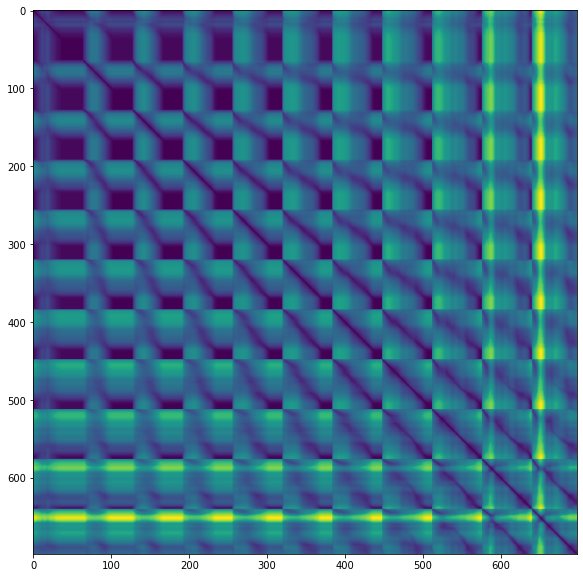

In [17]:
plt.figure(figsize = (10,10))
plt.imshow(D)

#### Question (b) Implement the ISOMAP algorithm yourself to obtain a two-dimensional low-dimensional embedding.

In [18]:
def isomap(matrix,k=2):
    
    m = matrix.shape[0]
    one = np.ones((m,1))
    I = np.eye(m)
    D = matrix
    
    #compute centering matrix H
    H = I - 1/m * (np.dot(one,one.T))
    
    #compute C matrix
    C = -1/2 * H @ D**2 @ H
    
    #calculate the eigenvalues and eigenvectors of C 
    eigen_values, eigen_vectors = np.linalg.eig(C)
    
    #sort them from largest to smallest
    eigen_vectors = eigen_vectors[:,np.argsort(-eigen_values)]
    eigen_values = eigen_values[np.argsort(-eigen_values)]

    #normailze the leading eigenvectors:
#     Z = eigen_vectors[:,:k] * np.sqrt(eigen_values[:k])
    Zt = np.dot(eigen_vectors[:,:k], np.diag(np.sqrt(eigen_values[:k])))
    
    return Zt

In [19]:
Z = isomap(D,k=2)

In [20]:
pd.DataFrame(Z[:5])

,0,1
0,-4.606329+0.000000j,0.496667+0.000000j
1,-4.491116+0.000000j,0.416249+0.000000j
2,-4.337952+0.000000j,0.291479+0.000000j
3,-4.220382+0.000000j,0.202180+0.000000j
4,-3.987320+0.000000j,0.115653+0.000000j


#### Plot the embeddings using a scatter plot

/home/zi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'a plot of the embedding using Euclidean Distnace')

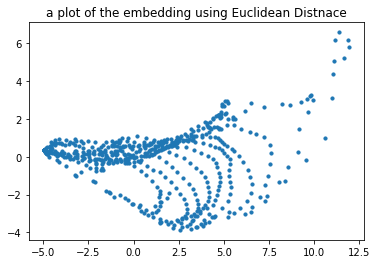

In [21]:
# Plot Embedding
plt.figure()
plt.scatter(Z[:,0], Z[:,1], s = 10)
plt.title("a plot of the embedding using Euclidean Distnace")


Text(0.5, 1.0, 'embedding_image_5')

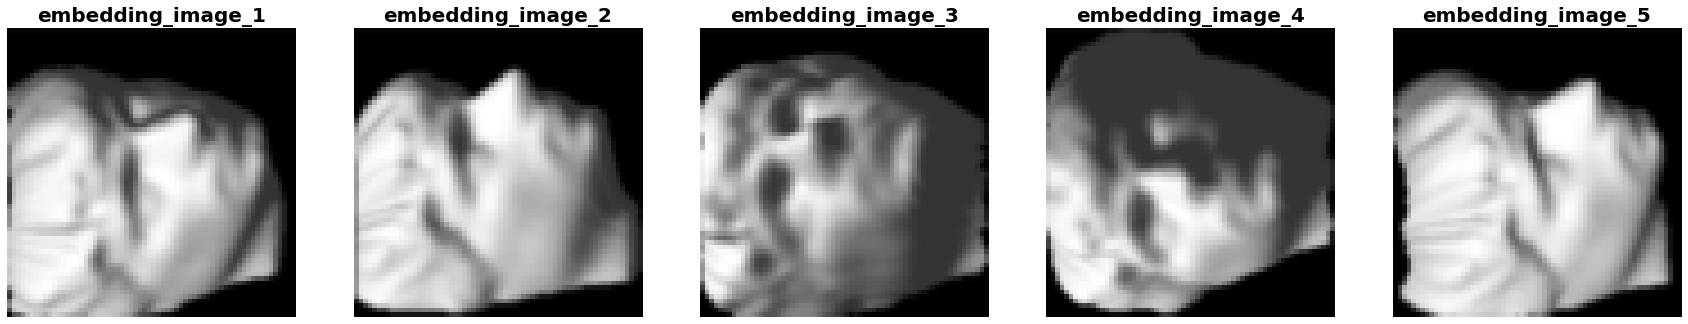

In [22]:
intro_fig, ax = subplots(1,5, figsize=(30,30))

idx = np.argsort(Z[:,0])[0:5]
img_1 = np.reshape(images.T[idx[0]], [64, -1])
img_2 = np.reshape(images.T[idx[1]], [64, -1])
img_3 = np.reshape(images.T[idx[2]], [64, -1])
img_4 = np.reshape(images.T[idx[3]], [64, -1])
img_5 = np.reshape(images.T[idx[4]], [64, -1])

ax[0].axis('off')
ax[0].imshow(img_1,cmap = 'gray')
ax[0].set_title('embedding_image_1', fontsize=20, weight='bold')
ax[1].axis('off')
ax[1].imshow(img_2,cmap = 'gray')
ax[1].set_title('embedding_image_2', fontsize=20, weight='bold')
ax[2].axis('off')
ax[2].imshow(img_3,cmap = 'gray')
ax[2].set_title('embedding_image_3', fontsize=20, weight='bold')
ax[3].axis('off')
ax[3].imshow(img_4,cmap = 'gray')
ax[3].set_title('embedding_image_4', fontsize=20, weight='bold')
ax[4].axis('off')
ax[4].imshow(img_5,cmap = 'gray')
ax[4].set_title('embedding_image_5', fontsize=20, weight='bold')

#### Oservation: The first 5 images in the embedding space are shown in above. As we can see, three out of 5 faces are faced up and two out of 5 faced to the front. There are some similarities among them, but not as high as expected. I think we should be able to improve that by increasing the the number of neighbors select for the nodes.

#### Question (c): Now choose l1 distance (or Manhattan distance) between images. Repeat the steps above.

In [23]:
A1 = build_similarity_graph(img,distance=1)

In [24]:
threshold1 = find_threhold(A1,num=50)
threshold1

188.18141850490196

#### Observation-1: by choosing the Manhattan Distance, the threshold is significantly higher in comparison to the Euclidean Distance.

In [25]:
A1_update = update_similarity_graph(A1,threshold1)

In [26]:
check_matrix(A1_update,50)

Great! There are at least 51 neighors for each node in the matrix!


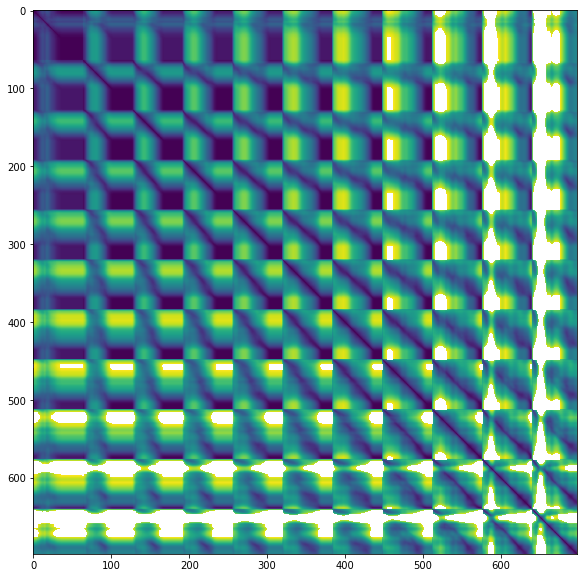

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(A1_update)

In [28]:
D1 = Matrix_D(A1_update)

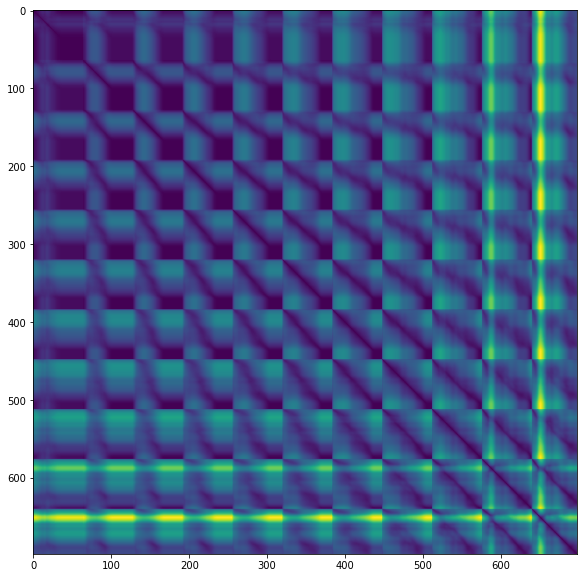

In [29]:
plt.figure(figsize = (10,10))
plt.imshow(D1)

In [30]:
Z1 = isomap(D1,k=2)

Text(0.5, 1.0, 'a plot of the embedding using Manhattan Distance')

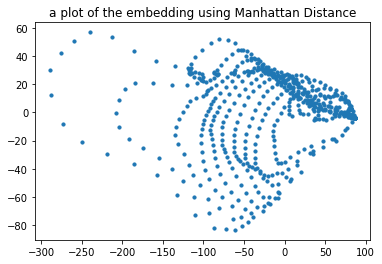

In [31]:
# Plot Embedding
plt.figure()
plt.scatter(Z1[:,0], Z1[:,1], s = 10)
plt.title("a plot of the embedding using Manhattan Distance")

Text(0.5, 1.0, 'embedding_image_5')

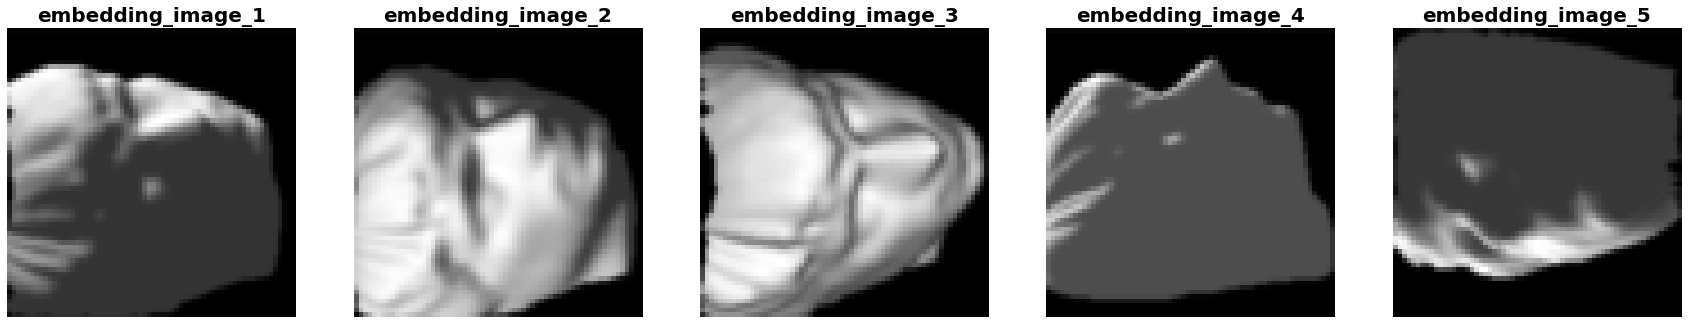

In [32]:
intro_fig, ax = subplots(1,5, figsize=(30,30))

idx = np.argsort(Z1[:,0])[0:5]
img_1 = np.reshape(images.T[idx[0]], [64, -1])
img_2 = np.reshape(images.T[idx[1]], [64, -1])
img_3 = np.reshape(images.T[idx[2]], [64, -1])
img_4 = np.reshape(images.T[idx[3]], [64, -1])
img_5 = np.reshape(images.T[idx[4]], [64, -1])

ax[0].axis('off')
ax[0].imshow(img_1,cmap = 'gray')
ax[0].set_title('embedding_image_1', fontsize=20, weight='bold')
ax[1].axis('off')
ax[1].imshow(img_2,cmap = 'gray')
ax[1].set_title('embedding_image_2', fontsize=20, weight='bold')
ax[2].axis('off')
ax[2].imshow(img_3,cmap = 'gray')
ax[2].set_title('embedding_image_3', fontsize=20, weight='bold')
ax[3].axis('off')
ax[3].imshow(img_4,cmap = 'gray')
ax[3].set_title('embedding_image_4', fontsize=20, weight='bold')
ax[4].axis('off')
ax[4].imshow(img_5,cmap = 'gray')
ax[4].set_title('embedding_image_5', fontsize=20, weight='bold')

#### Observation-2: Comparing to the results generated by Euclidean Distance, there are images from the Manhattan embedding very different from the rest (comparing image 5 to the rest of images). I feel that that Euclidean Distance is a better option for ISOMAP calculation because it can provide more accurate results.

#### Question (d) Perform PCA on the images and project them into the top 2 principal components

In [33]:
def PCA_algo(data):
    assert type(data) is np.ndarray
    assert len(data.shape) == 2
    
    # step 1. Subtract the mean of each variable
    data_meaned = data -np.mean(data,axis = 0)
    
    # step 2. Calculate the Covariance Matrix
    cov_matrix = np.cov(data_meaned, rowvar = False)
    
    #step 3. Calculating Eigenvalues and Eigenvectors of the covariance matrix
    eigen_values , eigen_vectors = np.linalg.eigh(cov_matrix)

    #step 4. sort the eigenvalues in descending order
    sort_idx = np.argsort(eigen_values)[::-1]

    eigen_values_s = eigen_values[sort_idx]
    eigen_vectors_s = eigen_vectors[:,sort_idx]
    
    return eigen_values_s,eigen_vectors_s

In [34]:
eigen_values_1, eigen_vectors_1 = PCA_algo(images.T)

In [35]:
pca = eigen_vectors_1[:,:2]

In [36]:
# pd.DataFrame(pca)

Text(0.5, 1.0, 'a plot of the embedding using PCA')

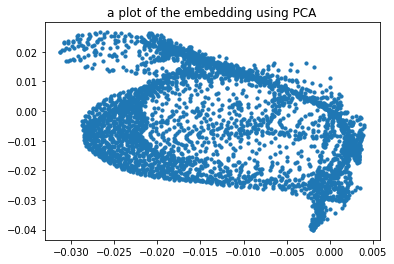

In [37]:
# Plot Embedding
plt.figure()
plt.scatter(pca[:,0], pca[:,1], s = 10)
plt.title("a plot of the embedding using PCA")

#### Observation: From the PCA embedding plot shown in above, we can see there are lots of nodes dense together. This is expected because the data is a nonlinear structure. And as a result PCA, a linear operation, is unable to reduce dimensionality appropriately. 